In [1]:
# %load_ext ipycache

# Recommendation Systems

Companies like Amazon (books, items), Netflix (movies), Google (News, Search), and Pandora/Spotify (music) leverage recommendation systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue.

The need to build robust recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

In this assignment, you will be applying your learning of recommendation systems in this Unit towards building the following four different types of recommendation systems:

1.   Global Recommendation Systems (Statistical)   
2.   Content-based Recommendation Systems
3.   Collaborative Filtering (User-Item) Recommendation Systems
4.   Hybrid Recommendation Systems

The focus of the mini-project here would be to build a movie recommendation system.


## 1. Dataset Acquisition

Following are the key descriptions of the datasets you will be using. The data used here has been compiled from various movie datasets like Netflix and IMDb.

1. __Filename: `movie_titles.csv`:__

  - __`MovieID`__: MovieID does not correspond to actual Netflix movie ids or IMDB movie ids
  - __`YearOfRelease`__: YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release
  - __`Title`__: Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English


2. __Combined User-Ratings Dataset Description - `combined_data.csv`:__

  - The first line of the contains the movie id followed by a colon.    
  - Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. 
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.


3. __Filename: `movies_metadata.csv`__

The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.


## 2: Import Necessary Dependencies

We will be leveraging __`keras`__ on top of __`tensorflow`__ for building some of the collaborative filtering and hybrid models. There are compatibility issues with handling sparse layers with dense layers till now in TensorFlow 2 hence we are leveraging native Keras but in the long run once this issue is resolved we can leverage __`tf.keras`__ with minimal code updates.

In [2]:
# Filter out unncessary warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
# to store\load the data
import pandas as pd

# to do linear algebra
import numpy as np

# to create plots
import matplotlib.pyplot as plt
import seaborn as sns


# to compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# to stack sparse matrices
from scipy.sparse import vstack

In [4]:
# to create deep learning models
import tensorflow as tf

# import keras
# from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
# from keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Reshape,
    Dot,
    Concatenate,
    Dense,
    Dropout,
)
from tensorflow.keras.models import Model

In [5]:
# remove unnecessary TF logs
import logging

tf.get_logger().setLevel(logging.ERROR)

In [6]:
# check keras and TF version used
print("TF Version:", tf.__version__)
print("Keras Version:", keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 2.5.0
Keras Version: 2.5.0


Let's start loading data that will be used for building the recommendation systems

# 3. Load Datasets

## 3.1: Load Movie Metadata Datasets

First, we will load the movie_titles.csv data from the Netflix prize data source

In [7]:
# Load data for all movies
movie_titles = pd.read_csv(
    "./data/movie_titles.csv.zip",
    encoding="ISO-8859-1",
    header=None,
    names=["Id", "Year", "Name"],
).set_index("Id")

In [8]:
print("Shape Movie-Titles:\t{}".format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
5653,1973.0,The Night Stalker / The Night Strangler
1971,1995.0,Under Siege 2: Dark Territory
3953,1973.0,Spook Who Sat by the Door
12439,2005.0,Strawberry Shortcake: Moonlight Mysteries
9431,2000.0,Get Carter


There are approximately 18000 movies in the ratings dataset and the metadata information includes the year of release and movie title

Next, we will load the movie_metadata.csv from The movies dataset source. This is to get the metadata information like description etc. related to each movie.

In [9]:
# Load a movie metadata dataset
# movie_metadata = (
movie_metadata_raw = (
    pd.read_csv("./data/movies_metadata.csv.zip", low_memory=False)[
        ["original_title", "overview", "vote_count"]
    ]
    .set_index("original_title")
    .dropna()
)

In [10]:
# Remove the long tail of rarely rated moves
movie_metadata = movie_metadata_raw[movie_metadata_raw["vote_count"] > 10].drop(
    "vote_count", axis=1
)
# movie_metadata = movie_metadata[movie_metadata["vote_count"] > 10].drop("vote_count", axis=1)

In [11]:
print("Shape Movie-Metadata:\t{}".format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Потомок Чингисхана,In 1918 a young and simple Mongol herdsman and...
Самый лучший фильм,Vadik Volnov (Garik Kharlamov) dies on his own...
Arsène Lupin,As the daring thief Arsène Lupin (Duris) ransa...
The Ten,"Ten stories, each inspired by one of the ten c..."
Cinderfella,This was Jerry Lewis' answer to the classic Ci...


Around 21,000 entries in the movies metadata dataset

## 3.2: Load User-Movie-Rating Dataset

In [12]:
# Dowload large file from the shared GDrive folder
# !pip install gdown
!gdown "https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2" -O data/

Downloading...
From: https://drive.google.com/uc?export=download&id=1z0O0fXuofdsbpL8fkCVgjeIwFP_LxGX2
To: C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-17.4.1-recommendation-systems-mini-project\data

0.00B [00:00, ?B/s]
524kB [00:00, 3.67MB/s]
1.57MB [00:00, 5.97MB/s]
2.62MB [00:00, 6.63MB/s]
3.67MB [00:00, 6.67MB/s]
4.72MB [00:00, 6.94MB/s]
5.77MB [00:00, 7.13MB/s]
6.82MB [00:00, 7.30MB/s]
7.86MB [00:01, 7.36MB/s]
8.91MB [00:01, 7.45MB/s]
9.96MB [00:01, 7.48MB/s]
11.0MB [00:01, 7.46MB/s]
12.1MB [00:01, 7.42MB/s]
13.2MB [00:01, 7.54MB/s]
14.2MB [00:01, 7.76MB/s]
15.3MB [00:02, 7.67MB/s]
16.3MB [00:02, 7.40MB/s]
17.4MB [00:02, 7.40MB/s]
18.4MB [00:02, 7.48MB/s]
19.5MB [00:02, 7.46MB/s]
20.5MB [00:02, 7.49MB/s]
21.6MB [00:02, 7.54MB/s]
22.6MB [00:03, 7.02MB/s]
24.1MB [00:03, 7.89MB/s]
25.2MB [00:03, 7.62MB/s]
26.2MB [00:03, 7.72MB/s]
27.3MB [00:03, 7.49MB/s]
28.3MB [00:03, 7.54MB/s]
29.4MB [00:03, 7.42MB/s]
30.3MB [00:04, 7.50

In [13]:
# Load single data file
df_raw = pd.read_csv(
    "./data/combined_data.csv.zip",
    header=None,
    names=["User", "Rating", "Date"],
    usecols=[0, 1, 2],
)

In [14]:
# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw["Rating"].isna()]["User"].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(
    movie_indices, shifted_movie_indices
):

    # Check if it is the last movie in the file
    if df_id_1 < df_id_2:
        tmp_df = df_raw.loc[df_id_1 + 1 : df_id_2 - 1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1 + 1 :].copy()

    # Create movie_id column
    tmp_df["Movie"] = movie_id

    # Append dataframe to list
    user_data.append(tmp_df)

In [15]:
# Combine all dataframes
df = pd.concat(user_data)

In [16]:
del (
    user_data,
    df_raw,
    tmp_movies,
    tmp_df,
    shifted_movie_indices,
    movie_indices,
    df_id_1,
    movie_id,
    df_id_2,
    next_movie_id,
)
print("Shape User-Ratings:\t{}".format(df.shape))
df.sample(10)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
12038359,2197570,5.0,2005-07-25,2342
9305784,808473,3.0,2003-01-01,1837
1301965,1785450,4.0,2005-04-15,290
15608422,641348,4.0,2005-05-01,3017
23915960,435450,3.0,2004-08-10,4472
5950509,526705,3.0,2005-02-06,1174
11127284,1328687,3.0,2004-01-01,2152
10125854,676073,3.0,2005-05-14,1962
20224892,1322167,3.0,2004-11-30,3860
16151164,1025572,4.0,2005-06-04,3138


There are about 24 Million+ different rating records!

We have taken the data required for building the system and now let's do some EDA on the dataset to better understand our data

# 4. Exploratory Data Analysis

## 4.1: When were the movies released?


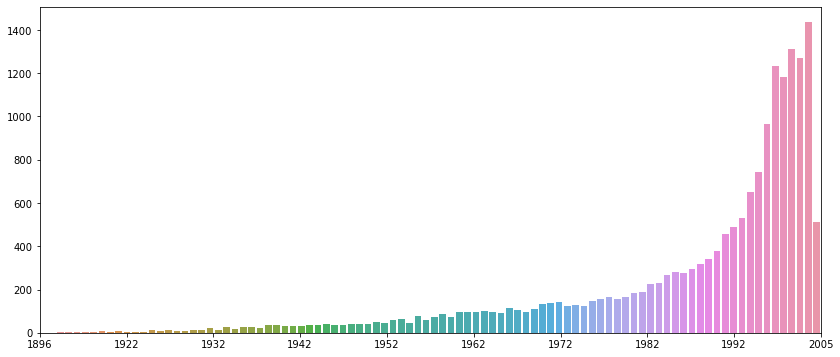

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles["Year"].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels)

plt.show()

Many movies on Netflix have been released in this millenium. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot. The decline for the rightmost point is probably caused by an incomplete last year.

## Q 4.2: How are the Ratings Distributed?

__Your Turn:__ Build the visualization for rating distributions similar to the previous plot.


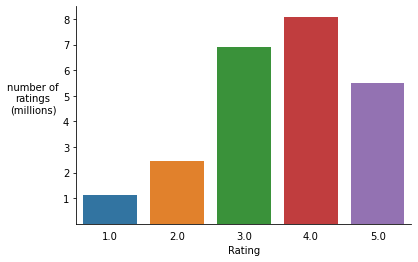

In [18]:
sns.countplot(x=df.Rating)
sns.despine(top=True, right=True)
plt.tick_params(axis="x", bottom=False)
plt.yticks(ticks=list(range(1000000, 9000000, 1000000)), labels=range(1, 9))
plt.ylabel("number of\nratings\n(millions)", labelpad=30).set_rotation(0)
plt.show()

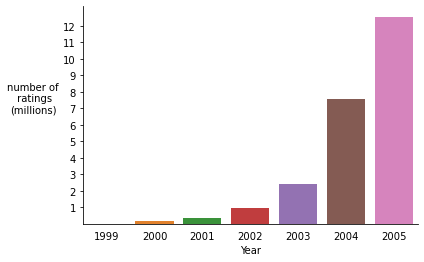

In [19]:
sns.countplot(pd.to_datetime(df.Date).dt.year)
sns.despine(top=True, right=True)
plt.tick_params(axis="x", bottom=False)
plt.xlabel("Year")
plt.yticks(ticks=list(range(1000000, 13000000, 1000000)), labels=range(1, 13))
plt.ylabel("number of\n ratings\n(millions)", labelpad=30).set_rotation(0)
plt.show()

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

## 4.3: Visualize the Distribution of Number of Movie Ratings 

This is to understand how many movies (y-axis) are receiving specific number of movie ratings (x-axis)

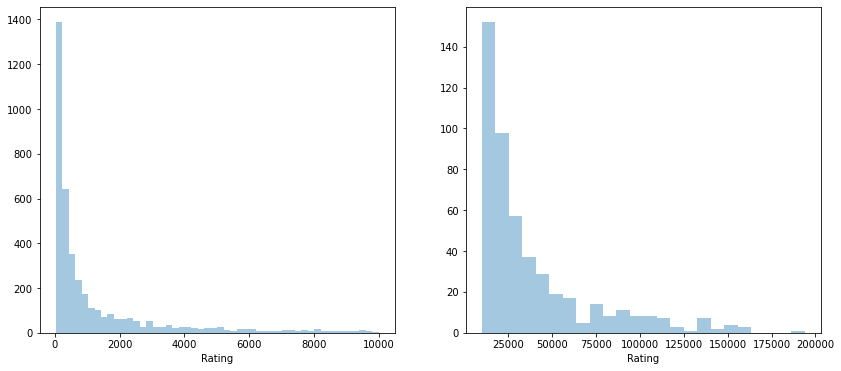

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby("Movie")["Rating"].count()
sns.distplot(data[data < 10000], kde=False, ax=ax[0])
sns.distplot(data[data > 10000], kde=False, ax=ax[1])

plt.show()

## Q 4.4: Visualize the Distribution of Number of User Ratings 

This is to understand how many users (y-axis) are giving specific number of movie ratings (x-axis)

__Your Turn:__ Try to find out an optimal threshold as in the previous example to split the data to form two understandable subplots!

In [21]:
plot_data = df.groupby("User")["Rating"].count()

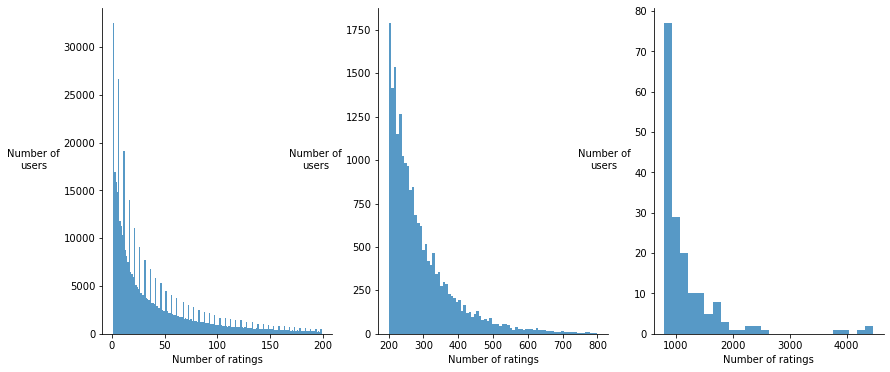

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
sns.despine(top=True, right=True)

for i, subplot_data in enumerate(
    (
        plot_data[plot_data < 200],
        plot_data[200 <= plot_data][plot_data <= 800],
        plot_data[800 < plot_data],
    )
):
    sns.histplot(subplot_data, ax=ax[i], linewidth=0)

for axis in ax:
    axis.set_xlabel("Number of ratings")
    axis.set_ylabel("Number of\nusers", rotation=0, labelpad=30)

plt.show()

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# 5. Dimensionality Reduction & Filtering

## Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.


In [23]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = df["Movie"].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = df["User"].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

In [24]:
# actual filtering
df_filtered = (
    df[(df["Movie"].isin(filter_movies)) & (df["User"].isin(filter_users))]
    .drop("Date", axis=1)
    .sample(frac=1, random_state=2021)  # Shuffle dataframe
    .reset_index(drop=True)
)

In [25]:
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print("Shape User-Ratings unfiltered:\t{}".format(df.shape))
print("Shape User-Ratings filtered:\t{}".format(df_filtered.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(5930581, 3)


After filtering sparse movies and users, about 5.9M rating records are present.

# 6. Create Train and Test Datasets

Do note this will be used for the statistical method-based models and collaborative filtering.

For content-based filtering, it is more of a model that recommends movies rather than predicting ratings and for the hybrid model, we will need to recreate the train and test datasets later since we need to create a subset of movies-users-ratings that have movie text descriptions.

## Create Train and Test datasets

In [26]:
# Shuffle DataFrame
# df_filtered = df_filtered.drop("Date", axis=1).sample(frac=1).reset_index(drop=True)

# testing size
n = 100000

# Split train & test sets
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
df_train.shape, df_test.shape

((5830581, 3), (100000, 3))

The train set will be used to train all models and the test set ensures we can compare model performance on unseen data using the RMSE metric.

# 7. Transformation

### Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

A large, sparse matrix will be created in this step. Each row will represent a user and its ratings and the columns are the movies.

The movies already rated by users are the non-empty values in the matrix.

Empty values are unrated movies and the main objective is to estimate the empty values to help our users.


__Your turn:__ Create the User-Movie matrix leveraging the __`pivot_table()`__ function from pandas.

Fill in the blanks in the code below by referencing the __`pivot_table()`__ function and invoking it on __`df_train`__. Feel free to check out the documentation.

Remember, rows should be users, columns should be movies and the values in the matrix should be the movie ratings. All these should be available in the __`df_train`__ dataframe.

In [27]:
# Create a user-movie matrix with empty values
# df_p = <YOUR CODE HERE>
df_p = df_train.pivot_table(values=["Rating"], index="User", columns="Movie")

In [28]:
print("Shape User-Movie-Matrix:\t{}".format(df_p.shape))
df_p.head(10)

Shape User-Movie-Matrix:	(20828, 1741)


Rating                                               ...            \
Movie     3    5    6    8    16   17   18   24   25   26    ... 4482 4483   
User                                                         ...             
1000079    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000192    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000301    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   
1000387    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000410    NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   
1000527    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000596    NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  ...  NaN  NaN   
1000634    NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000710    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1000779    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                 
Movie   4484 4485 4488 4489 4490 4492 4493 4496  
User                                             
1000079  NaN  NaN  2.0  NaN  NaN  NaN  NaN  NaN  
1000192  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000301  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  
1000387  NaN  1.0  2.0  NaN  NaN  1.0  NaN  NaN  
1000410  NaN  NaN  3.0  NaN  3.0  NaN  NaN  3.0  
1000527  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  
1000596  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000634  NaN  NaN  4.0  NaN  NaN  4.0  NaN  NaN  
1000710  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1000779  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  

[10 rows x 1741 columns]

## 8. Building Recommendation Systems

## 8.1(a): Global Recommendation Systems (Mean Rating)

Computing the mean rating for all movies creates a ranking. The recommendation will be the same for all users and can be used if there is no information on the user.
Variations of this approach can be separate rankings for each country/year/gender/... and to use them individually to recommend movies/items to the user.

It has to be noted that this approach is biased and favours movies with fewer ratings since large numbers of ratings tend to be less extreme in its mean ratings.

### Additional Hint

Predict model performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [29]:
# Compute mean rating for all movies
ratings_mean = (
    df_p.mean(axis=0).sort_values(ascending=False).rename("Rating-Mean").to_frame()
)

# Compute rating frequencies for all movies
ratings_count = df_p.count(axis=0).rename("Rating-Freq").to_frame()

In [30]:
# Combine the aggregated dataframes
# combined_df = ratings_mean.join(ratings_count).join(movie_titles)
combined_df = (
    ratings_mean.join(ratings_count).reset_index(level=0, drop=True).join(movie_titles)
)
combined_df.head(5)

,Rating-Mean,Rating-Freq,Year,Name
Movie,,,,
3456,4.654989,1313,2004.0,Lost: Season 1
2102,4.508273,2780,1994.0,The Simpsons: Season 6
3444,4.437922,2811,2004.0,Family Guy: Freakin' Sweet Collection
2452,4.426241,18574,2001.0,Lord of the Rings: The Fellowship of the Ring
2172,4.382576,6187,1991.0,The Simpsons: Season 3


In [31]:
# Join labels and predictions based on mean movie rating
# predictions_df = df_test.set_index("Movie").join(ratings_mean)
predictions_df = df_test.set_index("Movie").join(ratings_mean.reset_index(level=0, drop=True))
predictions_df.head(5)

,User,Rating,Rating-Mean
Movie,,,
3,2625471,4.0,3.453184
3,1854660,1.0,3.453184
3,2190996,3.0,3.453184
3,328674,3.0,3.453184
3,2054241,4.0,3.453184


In [32]:
# Compute RMSE
y_true = predictions_df["Rating"]
y_pred = predictions_df["Rating-Mean"]

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)

The RMSE Value for the Mean Rating Recommender: 1.0091164408999338


In [33]:
# View top ten rated movies
combined_df[["Name", "Rating-Mean"]].head(10)

,Name,Rating-Mean
Movie,,
3456,Lost: Season 1,4.654989
2102,The Simpsons: Season 6,4.508273
3444,Family Guy: Freakin' Sweet Collection,4.437922
2452,Lord of the Rings: The Fellowship of the Ring,4.426241
2172,The Simpsons: Season 3,4.382576
1256,The Best of Friends: Vol. 4,4.372022
3962,Finding Nemo (Widescreen),4.369309
4238,Inu-Yasha,4.368664
3046,The Simpsons: Treehouse of Horror,4.347048


## Q 8.1(b): Global Recommendation Systems (Weighted Rating)

To tackle the problem of the unstable mean with few ratings e.g. IMDb uses a weighted rating. Many good ratings outweigh few in this algorithm.

### Hint:

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

*𝑅* = average for the movie (mean) = (Rating)

*𝑣* = number of votes for the movie = (votes)

*𝑚* = minimum votes required 

*𝐶* = the mean vote across the whole report 

__Your Turn:__ Fill in the necessary code snippets below to build and test the model


In [34]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
# C = df_p.stack().mean()
C = df_p.stack().mean().values

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [35]:
# Weighted formula to compute the weighted rating
# weighted_score = <YOUR CODE HERE>
weighted_score = (v / (v + m)) * R + (m / (v + m)) * C
weighted_score

array([3.46278009, 3.45803027, 3.37912796, ..., 2.91434322, 3.26401465,
       3.63002711])

In [36]:
# convert weighted_score into a dataframe
# weighted_mean = <YOUR CODE HERE>
weighted_mean = pd.DataFrame(
    # create df out of weighted scores in rank order (descending)
    np.sort(weighted_score)[::-1],
    index=df_p.columns[
        # indices for movies in rank order (descending)
        np.argsort(weighted_score)[::-1]
    # movie IDs are level 1 of the multilevel index
    ].get_level_values(1),
    columns=["weighted mean rating"],
)
weighted_mean

,weighted mean rating
Movie,
2452,4.377281
3962,4.320542
4306,4.290075
2862,4.282691
3290,4.264780
...,...
4127,2.585198
2675,2.567810
3573,2.527782


In [37]:
# Combine the aggregated dataframes (weighted_mean & movie_titles)
# combined_df = <YOUR CODE HERE>
combined_df2 = weighted_mean.join(movie_titles, how="left")
combined_df2.head(5)

,weighted mean rating,Year,Name
Movie,,,
2452,4.377281,2001.0,Lord of the Rings: The Fellowship of the Ring
3962,4.320542,2003.0,Finding Nemo (Widescreen)
4306,4.290075,1999.0,The Sixth Sense
2862,4.282691,1991.0,The Silence of the Lambs
3290,4.264780,1974.0,The Godfather


In [38]:
# Join labels and predictions based on mean movie rating
# predictions_df = <YOUR CODE HERE>
predictions_df2 = df_test.set_index("Movie").join(weighted_mean, how="left")
predictions_df2.head(5)

,User,Rating,weighted mean rating
Movie,,,
3,2625471,4.0,3.46278
3,1854660,1.0,3.46278
3,2190996,3.0,3.46278
3,328674,3.0,3.46278
3,2054241,4.0,3.46278


In [39]:
del predictions_df, combined_df

In [40]:
# Compute RMSE
# y_true = <YOUR CODE HERE>
# y_pred = <YOUR CODE HERE>
y_true2 = predictions_df2["Rating"]
y_pred2 = predictions_df2["weighted mean rating"]

# rmse = <YOUR CODE HERE>
rmse = np.sqrt(mean_squared_error(y_true=y_true2, y_pred=y_pred2))
print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse)

The RMSE Value for the Weighted-Mean Rating Recommender: 1.0144717023938894


In [41]:
# View top ten rated movies
# <YOUR CODE HERE>
combined_df2[["Name", "weighted mean rating"]].sort_values(
    by="weighted mean rating", ascending=False
).head(10)

,Name,weighted mean rating
Movie,,
2452,Lord of the Rings: The Fellowship of the Ring,4.377281
3962,Finding Nemo (Widescreen),4.320542
4306,The Sixth Sense,4.290075
2862,The Silence of the Lambs,4.282691
3290,The Godfather,4.264780
2172,The Simpsons: Season 3,4.255309
2102,The Simpsons: Season 6,4.233044
2782,Braveheart,4.216019
3046,The Simpsons: Treehouse of Horror,4.201278


The variable "m" can be seen as regularizing parameter. Changing it determines how much weight is put onto the movies with many ratings.
Even if there is a better ranking the RMSE decreased slightly. There is a trade-off between interpretability and predictive power.

## 8.2: Content-Based Recommendation Systems


The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. If there is no historical data for a user or there is reliable metadata for each movie, it can be useful to compare the metadata of the movies to find similar ones.

![](./images/Content-based.png)

### Cosine TFIDF Movie Description Similarity

#### TF-IDF 

This is a text vectorization technique which is used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. 

IDF is the inverse of the document frequency among the whole corpus of documents. 

TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. 

In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

![](./images/TF-IDF-FORMULA.png)


#### Cosine Similarity 
After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors.

Consider the following example

![](./images/vector-space-model.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. 

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. 

The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. 

The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

In this approach, we will use the movie description to create a TF-IDF matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text vectors. This can easily be extended to more or different features if you like.
It is impossible for this model to compute a RMSE score since the model does not recommend the movies directly.
In this way, it is possible to find movies closely related to each other.

This approach of content-based filtering can be extendend to increase the model performance by adding some more features like genres, cast, crew etc.

In [42]:
# View sample movie descriptions
movie_metadata["overview"].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [43]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movie_metadata["overview"])

In [44]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(
    similarity, index=movie_metadata.index.values, columns=movie_metadata.index.values
)
similarity_df.head(10)

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Bloed, Zweet en Tranen",To Be Fat Like Me,Cadet Kelly,L'Homme à la tête de caoutchouc,Le locataire diabolique,L'Homme orchestre,Maa,Robin Hood
Toy Story,1.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.023356,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Jumanji,0.015385,1.000000,0.046854,0.000000,0.000000,0.047646,0.000000,0.000000,0.098488,0.0,...,0.000000,0.000000,0.0,0.004192,0.0,0.014642,0.000000,0.000000,0.000000,0.0
Grumpier Old Men,0.000000,0.046854,1.000000,0.000000,0.023903,0.000000,0.000000,0.006463,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.015409,0.000000,0.000000,0.007101,0.0
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007417,0.000000,0.008592,0.000000,0.0,...,0.028460,0.000000,0.0,0.000000,0.0,0.000000,0.016324,0.006840,0.000000,0.0
Father of the Bride Part II,0.000000,0.000000,0.023903,0.000000,1.000000,0.000000,0.030866,0.000000,0.033213,0.0,...,0.000000,0.000000,0.0,0.022816,0.0,0.000000,0.000000,0.000000,0.012584,0.0
Heat,0.000000,0.047646,0.000000,0.007417,0.000000,1.000000,0.000000,0.000000,0.046349,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.015837,0.000000,0.000000,0.0
Sabrina,0.000000,0.000000,0.000000,0.000000,0.030866,0.000000,1.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.028344,0.0,0.000000,0.105139,0.000000,0.000000,0.0
Tom and Huck,0.000000,0.000000,0.006463,0.008592,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.164136,0.071019,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006162,0.0
Sudden Death,0.000000,0.098488,0.000000,0.000000,0.033213,0.046349,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.014963,0.0
GoldenEye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.043867,0.000000,0.0,0.000000,0.0,0.076444,0.000000,0.016266,0.000000,0.0


In [45]:
# movie list
movie_list = similarity_df.columns.values

# sample movie
movie = "Batman Begins"

# top recommendation movie count
top_n = 10

# Get movie similarity records
movie_sim = similarity_df[similarity_df.index == movie].values[0]

# Get movies sorted by similarity
sorted_movie_ids = np.argsort(movie_sim)[::-1]

# Get recommended movie names
recommended_movies = movie_list[sorted_movie_ids[1 : top_n + 1]]

print("\n\nTop Recommended Movies for:", movie, "are:-\n", recommended_movies)



Top Recommended Movies for: Batman Begins are:-
 ['Batman Unmasked: The Psychology of the Dark Knight'
 'Batman: The Dark Knight Returns, Part 1' 'Batman: Bad Blood'
 'Batman: Year One' 'Batman: Under the Red Hood'
 'Batman Beyond: The Movie' 'Batman Forever'
 'Batman: Mask of the Phantasm' 'Batman & Bill' 'Batman']


__Your turn:__ Create a function as defined below, __`content_movie_recommender()`__, which can take in sample movie names and print a list of top N recommended movies.

In [46]:
def content_movie_recommender(
    input_movie,
    similarity_database=similarity_df,
    movie_database_list=movie_list,
    top_n=10,
):
    # <YOUR CODE HERE>
    print("Top {} recommendations based off {}:".format(top_n, input_movie))
    for rank, movie in enumerate(
        list(
            # Find the correct indices of movie_database_list
            movie_database_list[
                # Movie IDs (indices) rank ordered by similarity scores
                np.argsort(
                    # Similarity scores of other movies compared to the input movie
                    similarity_database[
                        similarity_database.index == input_movie
                    ].values[0]
                )[  # Start from -2 and move backwards (descending) to ignore input movie
                    -2 : -2 - top_n : -1
                ]
            ]
        )
    ):
        print("#{}\t{}".format(rank + 1, movie))
    print()

__Your turn:__ Test your function below on the given sample movies

In [47]:
sample_movies = [
    "Captain America",
    "The Terminator",
    "The Exorcist",
    "The Hunger Games: Mockingjay - Part 1",
    "The Blair Witch Project",
]

# <YOUR CODE HERE>
for movie in sample_movies:
    content_movie_recommender(movie)

Top 10 recommendations based off Captain America:
#1	Iron Man & Captain America: Heroes United
#2	Captain America: The First Avenger
#3	Team Thor
#4	Education for Death
#5	Captain America: The Winter Soldier
#6	49th Parallel
#7	Ultimate Avengers
#8	Philadelphia Experiment II
#9	Vice Versa
#10	The Lair of the White Worm

Top 10 recommendations based off The Terminator:
#1	Terminator 2: Judgment Day
#2	Terminator Salvation
#3	Terminator 3: Rise of the Machines
#4	Silent House
#5	They Wait
#6	Another World
#7	Teenage Caveman
#8	Appleseed Alpha
#9	Respire
#10	Just Married

Top 10 recommendations based off The Exorcist:
#1	Exorcist II: The Heretic
#2	Domestic Disturbance
#3	Damien: Omen II
#4	The Exorcist III
#5	Like Sunday, Like Rain
#6	People Like Us
#7	Quand on a 17 Ans
#8	Don't Knock Twice
#9	Zero Day
#10	Brick Mansions

Top 10 recommendations based off The Hunger Games: Mockingjay - Part 1:
#1	The Hunger Games: Catching Fire
#2	The Hunger Games: Mockingjay - Part 2
#3	Last Train from G

## 8.3: Collaborative Filtering Recommendation Systems

### Collaborative Filtering
Primarily recommends content to you based on inputs or actions from other people (say your friends).
![collaborative filtering](./images/collaborative-filtering.png)



### What is the intuition behind this?

*   **Personal tastes are correlated**


        1.   If Alice and Bob both like X and Alice likes Y, then Bob is more likely to like Y
        2.   especially (perhaps) if Bob knows Alice

Types of Collaborative Filtering:


1.   Neighborhood methods
2.   Matrix Factorization (Latent Factor) methods



Assume you don't have users. Rather, you have users' characterisics and properties (as shown in image).![Latent Factor method](https://miro.medium.com/max/876/1*AQEx38Wdo5H0WTSjRfAWtA.png)

For example, a person who is brave-hearted is more likely to be interested in dark, horrific movies rather than someone who is soft and compassionate.
* ^This is just an example (not in any literal sense)

So once you have the properties and characteristics of each user, we call them lower-dimensional features of the users. Similarly, we can have lower-dimensional features for movies (say its 10% action, 20% romance ...)

With these features, we represent users and movies in a low-dimensional space describing their properties. **This is called the latent space.**

We then recommend a movie based on its proximity to the user in the latent space.

### The problem:

The problem we try to address here is the rating prediction problem. 
Say, we try to guess how much Alice would rate a movie and suggest those movies that we think Alice will rate higher.

### Interesting... But how do we predict how much Alice would rate a movie?

 The data we have is a rating history: ratings of users for items in the interval [1,5]. We can put all this data into a sparse matrix called R:
 
 $R = 
 \begin{pmatrix}
  3 & ? &? \\ 
  ? & 4 & 5 \\
  ? & ? & 2 \\
  2 & 3 & ?
 \end{pmatrix}
 \begin{matrix}
  Alice \\ 
  Bob \\
  Chand \\
  Deb
 \end{matrix}
 $

 Each row of the matrix corresponds to a given user, and each column corresponds to a given item. For instance here, Alice has rated the first movie with a rating of 3 and Chand has rated the third item with a rating of 2.

 The matrix R is sparse (more than 99% of the entries are missing) and our goal is to predict the missing entries, i.e., predict the ?.


### Anatomy of the Rating matrix: LATENT SPACE
Before predicting ratings, lets step back and understand the latent space more! \\
 In this Rating matrix, Rows represent Users and Columns represent Movies.
 $R = 
  \begin{pmatrix}
  --Alice-- \\ 
  --Bob-- \\
  --Chand-- \\
  --Deb--
 \end{pmatrix}
 $

In latent space (low dimensional features - fanatics), for instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

```
Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ⋯ \\
Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ⋯ \\
: \\
Zoe = ⋯
```

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings.

$R ^ T = 
  \begin{pmatrix}
  --Avengers-- \\ 
  --Matrix-- \\
  --Inception-- \\
  --Sherlock--
 \end{pmatrix}
$

In the latent space, we will associate a semantic meaning behind each of the movies and these semantic meanings (say movie characteristics) can build back all of our original movies.

### EXAMPLE
In the below example, we convert users and movies to vectors (embeddings) and do dot-product to predict R.

user vector - U \\
movies vector - V \\
$
R = U.V
$

### Additional hints:

use dataframe map - [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)

Create tensor - [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input#view-aliases)

Create Embedding - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Dot product - [Dot](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Measure Performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

### Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL collaborative filtering system.

#### Create Configuration Parameters

In [48]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping = {id: i for i, id in enumerate(df_filtered["User"].unique())}
movie_id_mapping = {id: i for i, id in enumerate(df_filtered["Movie"].unique())}

In [49]:
# Use dataframe map function to map users & movies to mapped IDs based on above mapping
train_user_data = df_train["User"].map(user_id_mapping)
train_movie_data = df_train["Movie"].map(movie_id_mapping)

In [50]:
# Do the same for test data
# test_user_data = <YOUR CODE HERE>
# test_movie_data = <YOUR CODE HERE>
test_user_data = df_test["User"].map(user_id_mapping)
test_movie_data = df_test["Movie"].map(movie_id_mapping)

In [51]:
# Get input variable sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

#### Construct Deep Learning Model Architecture

In [52]:
test = tf.test
print(test.is_built_with_gpu_support())
print(test.is_built_with_cuda())
print(test.gpu_device_name())

True
True
/device:GPU:0


In [53]:
# Use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name="user")
# movie_id_input = <YOUR CODE HERE>
movie_id_input = Input(shape=(1,), name="movie")

In [54]:
# Create embedding layer for users
user_embedding = Embedding(
    output_dim=embedding_size, input_dim=users, input_length=1, name="user_embedding"
)(user_id_input)

# Create embedding layer for movies just like users
# movie_embedding = <YOUR CODE HERE>
movie_embedding = Embedding(
    output_dim=embedding_size, input_dim=movies, input_length=1, name="movie_embedding"
)(movie_id_input)

In [55]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
# movie_vector = <YOUR CODE HERE>
movie_vector = Reshape([embedding_size])(movie_embedding)

In [56]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [57]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       2082800     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       174100      movie[0][0]                      
______________________________________________________________________________________________

#### Train and Test the Model

In [58]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train["Rating"]

batch_size = 1024
epochs = 5
validation_split = 0.1

In [59]:
model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
)

Epoch 1/5
5125/5125 [==============================] - 106s 20ms/step - loss: 2.0695 - val_loss: 0.7759
Epoch 2/5
5125/5125 [==============================] - 106s 21ms/step - loss: 0.7396 - val_loss: 0.7242
Epoch 3/5
5125/5125 [==============================] - 105s 20ms/step - loss: 0.6762 - val_loss: 0.6970
Epoch 4/5
5125/5125 [==============================] - 104s 20ms/step - loss: 0.6148 - val_loss: 0.6876
Epoch 5/5
5125/5125 [==============================] - 98s 19ms/step - loss: 0.5506 - val_loss: 0.6971


In [60]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# Clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# Get true labels
y_true = df_test["Rating"].values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print("\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE".format(rmse))



Testing Result With DL Matrix-Factorization: 0.8383 RMSE


In [61]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame(
    {
        "User ID": test_user_data.values,
        "Movie ID": test_movie_data.values,
        "Movie Name": [movie_titles["Name"].iloc[item] for item in test_movie_data],
        "Predicted Rating": np.round(y_pred, 1),
        "Actual Rating": y_true,
    }
)

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,9672,61,Ken Burns' America: Empire of the Air,4.5,2.0
1,163,733,Indochine,2.5,3.0
2,10072,51,The Weather Underground,2.9,1.0
3,8562,37,Daydream Obsession,3.3,5.0
4,3197,139,Lost in the Wild,4.0,3.0
5,10292,379,Live Wire,1.9,3.0
6,12495,339,Midnight: 2000 Seen By...,4.2,5.0
7,4574,31,ABC Primetime: Mel Gibson's The Passion of the...,4.1,5.0
8,14366,954,Rhyme & Reason,4.4,5.0
9,12245,383,Crossroads,2.5,2.0


## 8.4: Hybrid Recommendation System (Content & Collaborative)

One advantage of deep learning models is that movie metadata can easily be added to the model.
We will tf-idf transform the short description of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to combine metadata with the embedding of the user-id and the movie-id. In this way we can add any additional metadata to our own recommender.
These kinds of hybrid systems can learn how to reduce the impact of the cold start problem.

Deep learning models require lots of data to train and predict. To provide our model with more data, we will include the movie metadata as well. We will do the following:


*   Use movie metadata to combine with user and movie matrices in order to get more data
*   Use tf-idf transform to vectorize movie metadata (Sparse Layer)
*   Create an embedding of the metadata 512 -> 256 
*   Combine all embeddings for movie tf-idf vectors, user and ratings to arrive at a common embedding space (256 sized embeddings per entity)
*   Use the embeddings to train the model and get predictions on the test data







### Additional Hints:

Dense layer setup :
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#example_2)

Create model using tf.keras API : 
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks)

Compile model using : [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Predict accuracy: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)



### Q8.3: Building a Deep Learning Hybrid Recommendation System

We will be building the following hybrid deep learning recommendation model as seen in the following schematic:

![](./images/hybrid-dl-model.png)

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL hybrid recommendation system.

#### Create Configuration Parameters

In [62]:
# Create a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [63]:
# Create user- & movie-id mapping
user_id_mapping = {id: i for i, id in enumerate(df_filtered_cp["User"].unique())}
movie_id_mapping = {id: i for i, id in enumerate(df_filtered_cp["Movie"].unique())}

In [64]:
# Use dataframe map function to map users & movies to mapped IDs based on above mapping
df_filtered_cp["User"] = df_filtered_cp["User"].map(user_id_mapping)
# df_filtered_cp["Movie"] = <YOUR CODE HERE>
df_filtered_cp["Movie"] = df_filtered_cp["Movie"].map(movie_id_mapping)

#### Create Movie Description Dataset (Content)

In [65]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()

# Preprocess titles
tmp_titles = movie_titles.drop("Year", axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index("Name")
tmp_titles.index = tmp_titles.index.str.lower()

# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index("Id")
df_id_descriptions["overview"] = df_id_descriptions["overview"].str.lower()
# del tmp_metadata,tmp_titles
print("Movie Description DF Shape:", df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6939, 1)


,overview
Id,
16182,daryl zero is a private investigator. along wi...
15233,"clear the runway for derek zoolander, vh1's th..."
1210,a newly arrived governor finds his province un...
17631,"in 1879, during the zulu wars, man of the peop..."
17631,"as a child, ali neuman narrowly escaped being ..."


In [66]:
del tmp_metadata, tmp_titles

#### Create User-Rating Filtered Dataset (Collaborative)

Here we filter out movie-user-ratings where movies don't have descriptions (content)

In [67]:
df_hybrid = (
    df_filtered_cp.set_index("Movie")
    .join(df_id_descriptions)
    .dropna()
    .drop("overview", axis=1)
    .reset_index()
    .rename({"index": "Movie"}, axis=1)
)
print("Movie-User-Rating DF Shape:", df_hybrid.shape)
df_hybrid.head()

Movie-User-Rating DF Shape: (2329938, 3)


,Movie,User,Rating
0,12,12,3.0
1,12,1037,2.0
2,12,2977,2.0
3,12,1718,2.0
4,12,4099,2.0


In [68]:
# Split train and test sets
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((2029938, 3), (300000, 3))

#### Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)

In [69]:
# Create tf-idf matrix for movie description vectors - HINT: check the overview column of df_id_descriptions
# tfidf = <YOUR CODE HERE>
tfidf = TfidfVectorizer(stop_words="english")
# tfidf_hybrid = tfidf.fit_transform(<YOUR CODE HERE>)
tfidf_hybrid = tfidf.fit_transform(df_id_descriptions["overview"])

In [70]:
# Get mapping from movie IDs to indices in tfidf-matrix
movie_idx_mapping = {id: i for i, id in enumerate(df_id_descriptions.index)}

In [71]:
# Get train data tfidf vectors
train_tfidf = []

# Iterate over all movie IDs and save the tfidf vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train["Movie"].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_hybrid[index])

len(train_tfidf)

100%|██████████| 2029938/2029938 [02:48<00:00, 12033.86it/s]


2029938

In [72]:
# Get test data tfidf vectors
# test_tfidf = []

# Iterate over all movie IDs and save the tfidf vectors (sparse format for memory efficiency)
# <YOUR CODE HERE>
test_tfidf = [
    tfidf_hybrid[movie_idx_mapping[idx]] for idx in tqdm(df_hybrid_test["Movie"].values)
]

len(test_tfidf)

100%|██████████| 300000/300000 [00:27<00:00, 11097.61it/s]


300000

In [73]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
# test_tfidf = <YOUR CODE HERE>
test_tfidf = vstack(test_tfidf)

In [74]:
train_tfidf.shape, test_tfidf.shape

((2029938, 24144), (300000, 24144))

In [75]:
type(train_tfidf)

scipy.sparse.csr.csr_matrix

This shows we are using sparse matrices to represent the vectors as dense vectors would typically give an out of memory error!

#### Construct Deep Learning Model Architecture

In [76]:
# Set up NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
tfidf_input_shape = tfidf_hybrid.shape[1]

In [77]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name="user")
# movie_id_input = <YOUR CODE HERE>
movie_id_input = Input(shape=(movieid_input_shape,), name="movie")

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name="tfidf", sparse=True)

In [78]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(
    output_dim=user_embed_dim,
    input_dim=len(user_id_mapping),
    input_length=userid_input_shape,
    name="user_embedding",
)(user_id_input)

# movie embedding
# movie_embedding = <YOUR CODE HERE>
movie_embedding = Embedding(
    output_dim=movie_embed_dim,
    input_dim=len(movie_id_mapping),
    input_length=movieid_input_shape,
    name="movie_embedding",
)(movie_id_input)

In [79]:
# Dimensionality reduction with dense layers
tfidf_vectors = Dense(512, activation="relu")(tfidf_input)
tfidf_vectors = Dense(256, activation="relu")(tfidf_vectors)

In [80]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
# movie_vectors = <YOUR CODE HERE>
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [81]:
# Concatenate all layers into one
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

In [82]:
# Add in dense and output layers
dense = Dense(512, activation="relu")(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

In [83]:
# Create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
tfidf (InputLayer)              [(None, 24144)]      0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 256)       5331968     user[0][0]                       
____________________________________________________________________________________________

#### Train and Test the Model

In [84]:
# validation_split parameter doesn't work with scipy sparse matrix or SparseTensor types
# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [85]:
# Fit the model
batch_size = 1024
epochs = 10
# X = [df_hybrid_train["User"], df_hybrid_train["Movie"], train_tfidf]
X = [
    df_hybrid_train["User"].to_numpy(),
    df_hybrid_train["Movie"].to_numpy(),
    tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(train_tfidf)),
]
# y = df_hybrid_train["Rating"]
y = df_hybrid_train["Rating"].to_numpy()

In [86]:
model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,  ## Change the epochs to find better improved model.
    # validation_split parameter doesn't work with scipy sparse matrix or SparseTensor types
    # validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
1983/1983 [==============================] - 126s 60ms/step - loss: 0.9202
Epoch 2/10
1983/1983 [==============================] - 138s 68ms/step - loss: 0.7919
Epoch 3/10
1983/1983 [==============================] - 140s 68ms/step - loss: 0.7532
Epoch 4/10
1983/1983 [==============================] - 138s 67ms/step - loss: 0.7244
Epoch 5/10
1983/1983 [==============================] - 140s 68ms/step - loss: 0.6963
Epoch 6/10
1983/1983 [==============================] - 145s 70ms/step - loss: 0.6697
Epoch 7/10
1983/1983 [==============================] - 142s 69ms/step - loss: 0.6425
Epoch 8/10
1983/1983 [==============================] - 145s 70ms/step - loss: 0.6169
Epoch 9/10
1983/1983 [==============================] - 151s 73ms/step - loss: 0.5912
Epoch 10/10
1983/1983 [==============================] - 146s 70ms/step - loss: 0.5679


In [87]:
# Create test input data and true outputs
# X_test = [df_hybrid_test["User"], df_hybrid_test["Movie"], test_tfidf]
X_test = [
    df_hybrid_test["User"].to_numpy(),
    df_hybrid_test["Movie"].to_numpy(),
    tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(test_tfidf)),
]
y_true = df_hybrid_test["Rating"].values

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# Clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print("\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE".format(rmse))



Testing Result With DL Hybrid Recommender: 0.8122 RMSE


In [88]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame(
    {
        "User ID": df_hybrid_test["User"].values,
        "Movie ID": df_hybrid_test["Movie"].values,
        "Movie Name": [
            movie_titles["Name"].iloc[item] for item in df_hybrid_test["Movie"]
        ],
        "Predicted Rating": np.round(y_pred, 1),
        "Actual Rating": y_true,
    }
)

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,10947,108,No Way Back,2.6,1.0
1,1657,486,Doctor Who: Lost in Time: The Patrick Troughto...,3.2,3.0
2,6531,606,Speed,2.8,3.0
3,6903,324,Ghosts of Rwanda: Frontline,3.3,3.0
4,16309,189,Blood and Sand,3.4,3.0
5,2647,505,Blank Generation / Dancin' Barefoot,2.6,3.0
6,5083,24,Inspector Morse 31: Death Is Now My Neighbour,3.9,4.0
7,4585,550,The Santa Clause,2.6,2.0
8,13802,148,The Edward R. Murrow Collection,3.0,3.0
9,408,954,Rhyme & Reason,4.1,4.0
